# Prototyping

Creates a neural network which evaluates a time series and produce a set of predicted values for the time series
Predicted values may be used in a policy to make a trade. This policy may be modeled by simple multiple regression or a neural network.

## Data
Test data is taken as most recent to avoid lookahead bias. Train data is split into a validation and training set during fitting.


## TODO
- Adding VIX as a signal
- Adding High/Low as signals
- Multiple securities/ aggregate samples
- Policy network
- Regularization (l2)
- Dilated convolution

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import pandas_datareader as pdr
from datetime import datetime
from scipy import stats


NUM_INPUT_NEURONS = 64
NUM_OUTPUT_NEURONS = 1
DAY_OFFSET = 5

def from_network(symbol):
    return pdr.get_data_yahoo(symbols=symbol, start=datetime(1900, 1, 1))

def from_file(symbol):
    dataset_path = keras.utils.get_file("{}.csv".format(symbol), "http://localhost:8000/data/daily/{}.csv".format(symbol))
    column_names = ['Date','Open','High','Low','Close','Adj Close','Volume'] 
    return pd.read_csv(dataset_path, 
                              names=column_names, 
                              dtype={'Close': np.float64,'Open': np.float64,'High': np.float64,'Adj Close': np.float64, 'Volume': np.float64},
                              header=0,
                              na_values = "?", 
                              comment='\t',
                              sep=",",
                              skipinitialspace=True)


# Create features (only close price for now)
def convert_to_percentage(old, new):
    return round((old - new) / old, 3)

def convert_labels_to_category(labels): 
    # Simplification - If positive return, 1, else 0
#     return map(lambda arr: [2] if arr[0] > 1 else [0], labels)
    # rounding simpliciation
    return map(lambda arr: map(lambda val: round(val,5),arr), labels)

def convert_to_train(raw_dataset, offset=5):
    dataset = raw_dataset.copy()
    features = []
    labels = []
    for i in range(offset, len(dataset) - NUM_INPUT_NEURONS):

        feature_dataset = dataset[i:i+NUM_INPUT_NEURONS].copy()
        latest_close = feature_dataset['Close'].iloc[0]
        
        close_features = feature_dataset['Close'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
        high_features = feature_dataset['High'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
        low_features = feature_dataset['Low'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
#         open_features = feature_dataset['Open'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
        features.append(
            zip(
                close_features,
                high_features,
                low_features,
#                 open_features,
            )
        )
        labels.append([
            dataset['Close'].iloc[i-1] / latest_close, # 1 day trade
#             dataset['High'].iloc[i-1] / latest_close, # 1 day trade
#             dataset['Low'].iloc[i-1] / latest_close, # 1 day trade
            
#             dataset['Close'].iloc[i-3] / latest_close, # 3 day trade
#             dataset['High'].iloc[i-3] / latest_close, # 1 day trade
#             dataset['Low'].iloc[i-3] / latest_close, # 1 day trade
            
#             dataset['Close'].iloc[i-5] / latest_close, # 5 day trade
#             dataset['High'].iloc[i-5] / latest_close, # 1 day trade
#             dataset['Low'].iloc[i-5] / latest_close, # 1 day trade
            
        ])
        
    # Without converting labels the precision is hard to determine accuracy. 
    # Rather than crude 0/1, maybe this can be more sophisticated
    labels = convert_labels_to_category(labels)
    
    return [features,labels]
def split_data(symbol):
    fetched = from_network(symbol).sort_values(by=['Date'],ascending=False)
    converted = convert_to_train(fetched)
    features = converted[0]
    labels = converted[1]
    prediction = [
        features[:5],
        labels[:5],
    ]
    validation = [
        features[5:1000],
        labels[5:1000]
    ]
    training = [
        features[1000:],
        labels[1000:]
    ]
    return {
        'symbol': symbol,
        'prediction': prediction,
        'validation': validation,
        'training': training,
    }

# retrain model and calculate difference - require convergence
def ranking_difference_squared(arr1, arr2):
    return sum(map(lambda element: (arr2.index(element)- arr1.index(element)) ** 2, arr1)) / len(arr1)

# is 208
print ranking_difference_squared(
    ['XLE', 'SPY', 'QQQ', 'XLP', 'XLU', 'XLV', 'XLY', 'XLI', 'XLK', 'XLF'],
    ['XLK', 'XLY', 'XLP', 'QQQ', 'XLI', 'SPY', 'XLV', 'XLU', 'XLF', 'XLE']
)
# is 0
print ranking_difference_squared(
    ['XLE', 'SPY', 'QQQ', 'XLP', 'XLU', 'XLV', 'XLY', 'XLI', 'XLK', 'XLF'],
    ['XLE', 'SPY', 'QQQ', 'XLP', 'XLU', 'XLV', 'XLY', 'XLI', 'XLK', 'XLF'],
)


20
0


In [2]:

# V = from_network('V')

In [3]:
QQQ = from_network('QQQ')
SPY = from_network('SPY')
XLK = from_network('XLK')
XLF = from_network('XLF')
XLE = from_network('XLE')
XLP = from_network('XLP')
XLV = from_network('XLV')
XLY = from_network('XLY')
XLI = from_network('XLI')
XLU = from_network('XLU')



In [4]:

prepped_data = map(split_data, [
    'QQQ',
    'SPY',
    'XLK',
    'XLF',
    'XLE',
    'XLP',
    'XLV',
    'XLY',
    'XLI',
    'XLU',
    'DIA',
#     'GOOG',
#     'IBM',
#     'AAPL',
#     'MSFT',
#     'ORCL',
#     'VMW',
#     'INTC',
])


In [5]:

for i in range(len(prepped_data)):
    print prepped_data[i]['symbol']
    
def combine_all(accum, prep):
    
    print len(accum['training'][0])
    return {   
        'prediction':[
            accum['prediction'][0] + prep['prediction'][0],
            accum['prediction'][1] + prep['prediction'][1],
        ],
        'validation':[
            accum['validation'][0] + prep['validation'][0],
            accum['validation'][1] + prep['validation'][1],
        ],
        'training':[
            accum['training'][0] + prep['training'][0],
            accum['training'][1] + prep['training'][1],
        ],
    }
combined = reduce(combine_all, prepped_data,{
    'prediction':[[],[]],
    'validation':[[],[]],
    'training':[[],[]],
})


QQQ
SPY
XLK
XLF
XLE
XLP
XLV
XLY
XLI
XLU
DIA
0
3938
9418
13408
17398
21388
25378
29368
33358
37348
41338


In [6]:

#init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
# len(combined['training'][0])

In [7]:
#len(converted_feature_set[0][0])
print len(combined['training'][0])
train_data = np.array(combined['training'][0])
train_labels = np.array(combined['training'][1])

print len(combined['validation'][0])
test_data = np.array(combined['validation'][0])
test_labels = np.array(combined['validation'][1])

print len(combined['prediction'][0])
prediction_data = np.array(combined['prediction'][0])
prediction_labels = np.array(combined['prediction'][1])


45562
10945
55


In [8]:
#print train_data
#print train_labels

In [9]:

def build_model():
  model = keras.Sequential([
    layers.Conv1D(64, kernel_size=(3), strides=(1),
        activation='relu',
        input_shape=(64,3)),
    layers.AveragePooling1D(27),
    layers.Flatten(),
    layers.Dense(64, activation=tf.nn.relu),
#     layers.Dense(48, activation=tf.nn.relu),
    layers.Dense(16, activation=tf.nn.relu),
      layers.Dense(16, activation=tf.nn.relu),
#     layers.Dense(24, activation=tf.nn.relu),
#     layers.Dense(18, activation=tf.nn.relu),
      
#     layers.Dense(64, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(48, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(36, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(24, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(12, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
    layers.Dense(NUM_OUTPUT_NEURONS)
  ])

  model.compile(
#       loss='mean_squared_logarithmic_error',
      loss='mean_squared_error',
#      loss='logcosh',
#       loss='mean_absolute_error',
    optimizer='sgd',
#       optimizer='adam',
#                 metrics=[
#                     'mae',
#                 ]
               )
  return model

tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 62, 64)            640       
_________________________________________________________________
average_pooling1d (AveragePo (None, 2, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total para

In [10]:
model.fit(
    train_data, train_labels,
    epochs=1, validation_data=(test_data, test_labels), verbose=1,
    callbacks=[tensorboard]
)
history = model.fit(
    train_data, train_labels,
    epochs=50, validation_data=(test_data, test_labels), verbose=1,
    callbacks=[tensorboard]
)

def train_model(model):
    return model.fit(
        train_data, train_labels,
        epochs=50, validation_data=(test_data, test_labels), verbose=1,
        callbacks=[tensorboard]
    )   

# model_1 = build_model()
# model_2 = build_model()
# model_3 = build_model()
# model_4 = build_model()

# map(train_model, [model_1, model_2, model_3, model_4])

Train on 45562 samples, validate on 10945 samples
Epoch 1/1
45562/45562 [==============================] - 3s 68us/step - loss: 0.0068 - val_loss: 1.0983e-04
Train on 45562 samples, validate on 10945 samples
Epoch 1/50
45562/45562 [==============================] - 3s 66us/step - loss: 2.2861e-04 - val_loss: 1.0791e-04
Epoch 2/50
45562/45562 [==============================] - 3s 64us/step - loss: 2.2626e-04 - val_loss: 1.0679e-04
Epoch 3/50
45562/45562 [==============================] - 3s 66us/step - loss: 2.2542e-04 - val_loss: 1.0636e-04
Epoch 4/50
45562/45562 [==============================] - 3s 66us/step - loss: 2.2473e-04 - val_loss: 1.0585e-04
Epoch 5/50
45562/45562 [==============================] - 3s 67us/step - loss: 2.2426e-04 - val_loss: 1.0645e-04
Epoch 6/50
45562/45562 [==============================] - 3s 65us/step - loss: 2.2384e-04 - val_loss: 1.0670e-04
Epoch 7/50
45562/45562 [==============================] - 3s 65us/step - loss: 2.2359e-04 - val_loss: 1.0517e-04
E

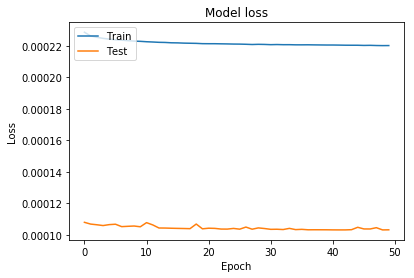

In [11]:
import matplotlib.pyplot as plt


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
outputs = model.predict(test_data)

In [13]:

print stats.describe(test_labels)
print stats.describe(outputs)

DescribeResult(nobs=10945, minmax=(array([0.94642]), array([1.06244])), mean=array([1.00028325]), variance=array([0.00010277]), skewness=array([-0.31277511]), kurtosis=array([3.28245358]))
DescribeResult(nobs=10945, minmax=(array([0.9976932], dtype=float32), array([1.0052711], dtype=float32)), mean=array([1.0005981], dtype=float32), variance=array([2.5568315e-07], dtype=float32), skewness=array([0.6881924], dtype=float32), kurtosis=array([8.06791], dtype=float32))


In [14]:
print outputs[0]
print test_labels[0]
print test_data[0]


[0.9988266]
[1.00788]
[[ 0.    -0.009  0.   ]
 [-0.    -0.002  0.015]
 [ 0.019  0.015  0.023]
 [ 0.01   0.009  0.016]
 [ 0.007  0.006  0.022]
 [ 0.009  0.005  0.018]
 [ 0.017  0.014  0.032]
 [ 0.026  0.021  0.038]
 [ 0.038  0.033  0.065]
 [ 0.077  0.056  0.079]
 [ 0.046  0.041  0.071]
 [ 0.05   0.045  0.059]
 [ 0.058  0.042  0.065]
 [ 0.057  0.056  0.094]
 [ 0.061  0.06   0.112]
 [ 0.116  0.089  0.116]
 [ 0.091  0.051  0.096]
 [ 0.062  0.04   0.074]
 [ 0.048  0.01   0.055]
 [ 0.024  0.015  0.033]
 [ 0.03   0.004  0.038]
 [ 0.008 -0.009  0.01 ]
 [-0.017 -0.028 -0.01 ]
 [-0.017 -0.032 -0.016]
 [-0.008 -0.021  0.001]
 [-0.004 -0.009  0.018]
 [ 0.006 -0.029  0.009]
 [-0.028 -0.028  0.004]
 [-0.021 -0.059 -0.02 ]
 [-0.061 -0.068 -0.044]
 [-0.043 -0.044 -0.032]
 [-0.036 -0.043 -0.028]
 [-0.039 -0.039 -0.007]
 [-0.007 -0.009  0.007]
 [-0.003 -0.004  0.01 ]
 [ 0.019  0.009  0.02 ]
 [ 0.012  0.002  0.019]
 [ 0.02   0.006  0.032]
 [ 0.002 -0.028  0.005]
 [-0.032 -0.037 -0.021]
 [-0.035 -0.038 -0

In [15]:
# primitive policy temporarily in place of a RL policy network

# signal step for our policy network
signals = map(lambda arr: sum(arr) / len(arr),outputs)
# signals = map(lambda arr: arr[0],outputs)
trades = map(lambda signal: 1 if round(signal,4) > 1 else 0,signals)

In [16]:
zip(signals, outputs)

[(0.9988266229629517, array([0.9988266], dtype=float32)),
 (0.9985748529434204, array([0.99857485], dtype=float32)),
 (0.9987642765045166, array([0.9987643], dtype=float32)),
 (0.9987156391143799, array([0.99871564], dtype=float32)),
 (0.9986258745193481, array([0.9986259], dtype=float32)),
 (0.9987436532974243, array([0.99874365], dtype=float32)),
 (0.9987540245056152, array([0.998754], dtype=float32)),
 (0.9988746643066406, array([0.99887466], dtype=float32)),
 (0.9992510080337524, array([0.999251], dtype=float32)),
 (0.9998475313186646, array([0.99984753], dtype=float32)),
 (1.0003490447998047, array([1.000349], dtype=float32)),
 (1.0007517337799072, array([1.0007517], dtype=float32)),
 (1.0009807348251343, array([1.0009807], dtype=float32)),
 (1.0007734298706055, array([1.0007734], dtype=float32)),
 (1.0002230405807495, array([1.000223], dtype=float32)),
 (0.9987387657165527, array([0.99873877], dtype=float32)),
 (0.9997062683105469, array([0.99970627], dtype=float32)),
 (1.0003883

In [17]:
# one day return
actual = map(lambda arr: arr[0],test_labels)

df = pd.DataFrame({
    'signal':signals,
    'actual': actual,
    'trade':trades,
})

In [18]:
df['entry_success'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 1) else 0,axis=1)
df['entry_failure'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 1) else 0,axis=1)
df['avoid_success'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 0) else 0,axis=1)
df['avoid_failure'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 0) else 0,axis=1)


In [19]:
# primitive policy - replace with a policy network which maximizes reward
def label_success (row):
    return 0 if (row['entry_failure'] == 1 or row['entry_failure'] == 1) else 1

success = df.apply (lambda row: label_success (row),axis=1)
df['success'] = success;
df

,actual,signal,trade,entry_success,entry_failure,avoid_success,avoid_failure,success
0,1.00788,0.998827,0,0,0,0,1,1
1,0.99982,0.998575,0,0,0,1,0,1
2,1.01953,0.998764,0,0,0,0,1,1
3,0.99116,0.998716,0,0,0,1,0,1
4,0.99634,0.998626,0,0,0,1,0,1
5,1.00286,0.998744,0,0,0,0,1,1
6,1.00815,0.998754,0,0,0,0,1,1
7,1.00905,0.998875,0,0,0,0,1,1
8,1.01191,0.999251,0,0,0,0,1,1
9,1.04278,0.999848,0,0,0,0,1,1


In [20]:
print df['actual'].corr(df['signal'])
print df['actual'].corr(df['trade'])
print df['actual'].corr(df['entry_success'])
print df['actual'].corr(df['success'])


-0.0033898266633879187
-0.0318982533849221
0.6162504415752937
0.6405107917689666


In [21]:
df['actual'].describe()

count    10945.000000
mean         1.000283
std          0.010138
min          0.946420
25%          0.995830
50%          1.000590
75%          1.005450
max          1.062440
Name: actual, dtype: float64

In [22]:
df['signal'].describe()

count    10945.000000
mean         1.000598
std          0.000506
min          0.997693
25%          1.000397
50%          1.000588
75%          1.000800
max          1.005271
Name: signal, dtype: float64

In [23]:
NUM_TEST_SAMPLES = len(test_data)
print NUM_TEST_SAMPLES

print '\nPrecision' # optimize for this since we can increase discovery, so long as we find enough trades
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['entry_failure'])) 

print '\nRecall'
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['avoid_failure']))

print '\nAccuracy'
print sum(df['entry_success']) * 1.00 / (NUM_TEST_SAMPLES)

print '\nNon-loss events'
print sum(df['success'])
print sum(df['success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nLose trades'
print sum(df['entry_failure'])
print sum(df['entry_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nWin trades'
print sum(df['entry_success'])
print sum(df['entry_success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nMissed opportunities'
print sum(df['avoid_failure'])
print sum(df['avoid_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nBullets dodged'
print sum(df['avoid_success'])
print sum(df['avoid_success']) / (NUM_TEST_SAMPLES * 1.00)


10945

Precision
0.535109686467

Recall
0.916766775356

Accuracy
0.488076747373

Non-loss events
6304
0.575970762905

Lose trades
4641
0.424029237095

Win trades
5342
0.488076747373

Missed opportunities
485
0.0443124714481

Bullets dodged
394
0.0359981726816


In [24]:
weights, biases = model.layers[0].get_weights()


In [25]:
#list(weights)

In [26]:
predictions = [
    ['SPY', model.predict(np.array(convert_to_train(SPY.copy(), 0)[0][:1]))],
    ['QQQ', model.predict(np.array(convert_to_train(QQQ.copy(), 0)[0][:1]))],
    ['XLE', model.predict(np.array(convert_to_train(XLE.copy(), 0)[0][:1]))],
    ['XLF', model.predict(np.array(convert_to_train(XLF.copy(), 0)[0][:1]))],
    ['XLK', model.predict(np.array(convert_to_train(XLK.copy(), 0)[0][:1]))],
    ['XLP', model.predict(np.array(convert_to_train(XLP.copy(), 0)[0][:1]))],
    ['XLV', model.predict(np.array(convert_to_train(XLV.copy(), 0)[0][:1]))],
    ['XLU', model.predict(np.array(convert_to_train(XLU.copy(), 0)[0][:1]))],
    ['XLY', model.predict(np.array(convert_to_train(XLY.copy(), 0)[0][:1]))],
    ['XLI', model.predict(np.array(convert_to_train(XLI.copy(), 0)[0][:1]))],
]

predictions.sort(key=lambda x: x[1],reverse=True)

In [27]:
def print_arg(arr):
    print '{} {}'.format(arr[0],str(arr[1]))
    return arr[0]
print map(print_arg, predictions)


XLV [[1.0015768]]
XLI [[1.0010378]]
XLY [[1.0009767]]
SPY [[1.0008149]]
XLP [[1.0006926]]
XLE [[1.0004796]]
XLU [[1.0002496]]
XLF [[1.000224]]
XLK [[0.9989884]]
QQQ [[0.9987887]]
['XLV', 'XLI', 'XLY', 'SPY', 'XLP', 'XLE', 'XLU', 'XLF', 'XLK', 'QQQ']


In [28]:
# print ranking_difference_squared( # pool 27 , 64 , 32
#     ['XLE', 'SPY', 'QQQ', 'XLP', 'XLU', 'XLV', 'XLY', 'XLI', 'XLK', 'XLF'],
#     ['XLK', 'XLY', 'XLP', 'QQQ', 'XLI', 'SPY', 'XLV', 'XLU', 'XLF', 'XLE'],
#     ['XLE', 'XLF', 'XLV', 'SPY', 'XLI', 'XLU', 'XLY', 'XLK', 'XLP', 'QQQ'], # 14
#     ['XLF', 'XLK', 'XLP', 'XLE', 'XLU', 'SPY', 'XLI', 'QQQ', 'XLY', 'XLV'], #10
#     ['XLF', 'XLE', 'XLU', 'XLY', 'XLV', 'XLK', 'SPY', 'XLP', 'XLI', 'QQQ'], #8
#     ['XLE', 'XLK', 'XLV', 'XLU', 'XLY', 'XLP', 'XLI', 'XLF', 'SPY', 'QQQ'],   
# )

print ranking_difference_squared( # pool 27 , 64 , 16, 16
#     ['XLK', 'QQQ', 'XLE', 'XLF', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU', 'SPY'], #3
#     ['XLK', 'XLF', 'XLE', 'QQQ', 'XLY', 'XLV', 'XLU', 'XLP', 'XLI', 'SPY'],#7
['XLK', 'QQQ', 'XLV', 'XLP', 'XLF', 'XLU', 'XLE', 'SPY', 'XLY', 'XLI'],
    ['XLV', 'XLY', 'XLK', 'XLI', 'SPY', 'QQQ', 'XLU', 'XLE', 'XLP', 'XLF']


    
)

17


In [29]:
model.predict(np.array(convert_to_train(V.copy(), 0)[0][:1]))

NameError: name 'V' is not defined

In [ ]:
XLF [[1.001202]]
XLU [[1.0010362]]
XLE [[1.0009055]]
XLY [[1.00064]]
XLI [[1.0004723]]
XLP [[1.0000945]]
SPY [[0.99986994]]
XLV [[0.9995481]]
QQQ [[0.9991982]]
XLK [[0.9978423]]
['XLF', 'XLU', 'XLE', 'XLY', 'XLI', 'XLP', 'SPY', 'XLV', 'QQQ', 'XLK']